# Synopsis:
- Load data for 1 patient
- Look at slice at index 70 in X & Y
- Reshape data into format TF expects
- Normalize input data 
- Make and train model
- Plot loss ( 1 - dice coefficient )
- Plot predicted mask and accuracy metric ( dice coefficient )

In [1]:
import utils.hgg_utils as hu
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 
from model import unet
from utils.dice import dice_loss as dice
from utils.dice import dice_coef as dice_coef

In [2]:
START = 70
STOP = 71

### Get path to 0th patient folder

In [3]:
path_to_patient_folder = hu.get_each_hgg_folder()[0]

### Load patient 0 multimodal tensor

In [4]:
X = hu.get_a_multimodal_tensor( path_to_patient_folder )

### Load patient 0 mask tensor

In [5]:
Y = hu.get_a_mask_tensor( path_to_patient_folder )

### Convert mask to binary mask

In [6]:
Y = hu.convert_mask_to_binary_mask(Y)

### Verify X & Y

#### Look at slice at index 70 in X

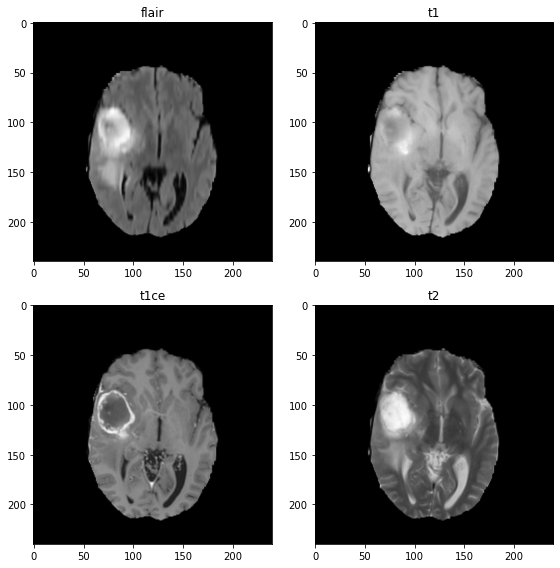

In [7]:
hu.print_multimodal_slice(X, slice_idx=START)

#### Look at slice 70 in BINARY mask

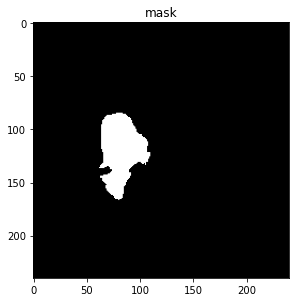

In [8]:
hu.print_multimodal_slice(Y, slice_idx=START)

### Move slices axis to the front so we can batch later

#### X 155 Slices are in index 2, we want them index 0

In [9]:
X.shape

(240, 240, 155, 4)

In [10]:
reshaped_X = hu.reshape_tensor_with_slices_first( X )

#### X Now the 155 slices are in index 0

In [11]:
reshaped_X.shape

(155, 240, 240, 4)

#### Y 155 Slices are in index 2, we want them index 0

In [12]:
Y.shape

(240, 240, 155, 1)

In [13]:
reshaped_Y = hu.reshape_tensor_with_slices_first( Y )

#### X Now the 155 slices are in index 0

In [14]:
reshaped_Y.shape

(155, 240, 240, 1)

### Rough Normalize by channels

#### Check max & min before normalizing

In [18]:
print( "MAX", reshaped_X[:,:,:,3].max() )
print( "MIN", reshaped_X[:,:,:,3].min() )

MAX 1584.0
MIN 0.0


#### Normalize multimodal tensor

In [19]:
for modality in range(reshaped_X.shape[-1]):
    reshaped_X[:,:,:,modality] /= reshaped_X[:,:,:,modality].max()

#### Check max & min after normalizing

In [20]:
print( "MAX", reshaped_X[:,:,:,3].max() )
print( "MIN", reshaped_X[:,:,:,3].min() )

MAX 1.0
MIN 0.0


### Model accepts a single multimodal slice (240, 240, 4) 

#### ds is the factor we are dividing the number of filters in each conv layer by 

In [15]:
model = unet( input_size=(240,240,4), ds=1 )

#### necessary for backprop later

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [17]:
#model.summary()

# Train with functional model
# Overfitting model on 1 slice from a multimodal tensor for 1 patient

#### Collect loss for every epoch so it can be plotted
#### note: losses sits outside of the training cell in case you need to train more
       it saves previous epochs of training
       - if you reinitialize the model you will want to rerun the losses = [] cell 
         to reset the training history

In [21]:
losses = []

#### This is instead of model.fit()
#### Indentation matters here

In [29]:
for epoch in tqdm(range(1000)):
    
    with tf.GradientTape() as tape:

        # Forward Pass
        pred = model( reshaped_X[START:STOP,:,:,:] )

        # Calculate Loss
        loss = dice(truth=reshaped_Y[START,:,:,0], prediction=pred[0,:,:,0])

        # Collect each loss for plotting
        losses.append(loss)
        
    # Get gradients 
    grads = tape.gradient(loss, model.trainable_variables)
    
    # Backpropagation
    optimizer.apply_gradients( zip(grads, model.trainable_variables) )

# Plot Training Loss over Epochs

#### Want Loss to go down from 1 to 0
#### If loss gets stuck at 1, reinitialize the model's weights by rerunning the model = unet() cell above

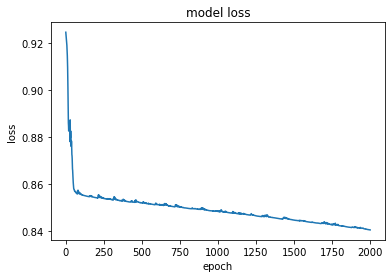

In [30]:
plt.plot(losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Look at thresholded predicted mask & accuracy (dice coefficient) for our 1 example

- For loss we are using dice loss, which we awant to be low close to 0
- For accuracy we are using dice coefficient ie. (1 - dice loss) which we want to be high near 1

Dice Coef  Before Thresholding: 0.16


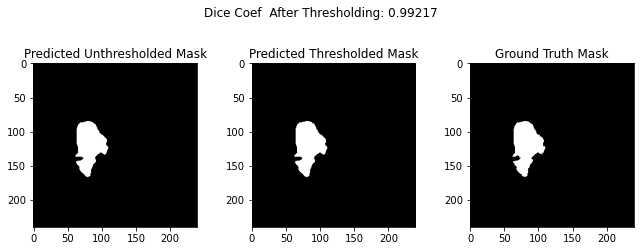

In [32]:
a = model( reshaped_X[START:STOP,:,:,:] ).numpy()
b = reshaped_Y[START,:,:,0]

print(
    "Dice Coef  Before Thresholding: {:.2f}".format( dice_coef(a, b).numpy())
)


plt.figure(figsize=(9, 4))

# plot unthresholded prediction
plt.subplot(131)
plt.title("Predicted Unthresholded Mask")
plt.imshow( model( reshaped_X[START:STOP,:,:,:] ).numpy()[0,:,:,0].T, cmap="Greys_r"  ) 

# Threshold the prediction ie. turn it to binary
a[np.where(a >= 0.5) ] = 1
a[np.where(a < 0.5) ] = 0

# plot thresholded prediction
plt.subplot(132)
plt.title("Predicted Thresholded Mask")
plt.imshow( a[0,:,:,0].T, cmap="Greys_r"  )  

# plot binary mask
plt.subplot(133)
plt.title("Ground Truth Mask")
plt.imshow( b.T, cmap="Greys_r"  )

title = "Dice Coef  After Thresholding: {:.5f}".format( dice_coef(a, b).numpy()) #+ "    Dice Loss After Thresholding: {:.2f}".format( dice(a, b).numpy())

plt.suptitle(title)
plt.tight_layout()
plt.show()